In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

plt.rcParams["figure.figsize"] = (14, 8)
sns.set_style("whitegrid")

## Problem 4.5

In [2]:
def uniform_sampler(size, theta=2, seed=0):
    """Draw uniform samples with upper bound.

    Args:
        size (int): Number of samples to draw.
        theta (float): Positive float denoting the upper bound
            of the underlying uniform distribution. Defaults to 2.
        seed (int): Random number generator seed. Defaults to 1.

    Returns:
        samples (np.ndarray): 1d array containing samples.

    """
    np.random.seed(seed)
    samples = np.random.uniform(high=theta, size=size)
    return samples

In [3]:
def estimator_naive(sample):
    """Estimate upper bound of uniform variables.

    Estimates parameter using:

        \hat{\theta} = 2 * sum_i sample_i

    Args:
        sample (np.ndarray): 1d array of uniform samples.

    Returns:
        estimate (float): Estimate of upper bound of
            theoretical uniform distibution.

    """
    estimate = 2 * sample.mean()
    return estimate

In [4]:
def estimator_super_consistent(sample):
    """Estimate upper bound of uniform variables.

    Estimates parameter using:

        \tilde{\theta} = \max_i sample_i,

    which results in a super-consistent estimator.

    Args:
        sample (np.ndarray): 1d array of uniform samples.

    Returns:
        estimate (float): Estimate of upper bound of
            theoretical uniform distibution.

    """
    estimate = sample.max()
    return estimate

### i) and ii)

In [5]:
samples = uniform_sampler(size=100)

In [6]:
estimator_naive(samples)

1.8911753580500708

In [7]:
estimator_super_consistent(samples)

1.9767476761184524

### a) and b)

In [8]:
def monte_carlo_study(runs=10_000, sample_size=100, theta=2):
    """Study behavior of the above estimators.

    Args:
        runs (int): Monte Carlo runs. Defaults to 10_000.
        sample_size (int): Sample size in each run. Defaults to 100.
        theta (float): Positive float denoting the upper bound
            of the underlying uniform distribution. Defaults to 2.

    Returns:
        df (pd.DataFrame): Tidy data frame containing simulation results.

    """
    results = np.empty((runs, 2))
    for run in range(runs):
        sample = uniform_sampler(size=sample_size, theta=theta, seed=run)
        naive = estimator_naive(sample)
        super_consistent = estimator_super_consistent(sample)
        results[run, 0] = naive
        results[run, 1] = super_consistent

    df = pd.DataFrame(results, index=range(runs), columns=["naive", "super_consistent"])

    df = df.melt(value_name="estimate", var_name="estimator")
    return df

In [9]:
df = monte_carlo_study(runs=10_000)

<AxesSubplot:xlabel='estimate', ylabel='Count'>

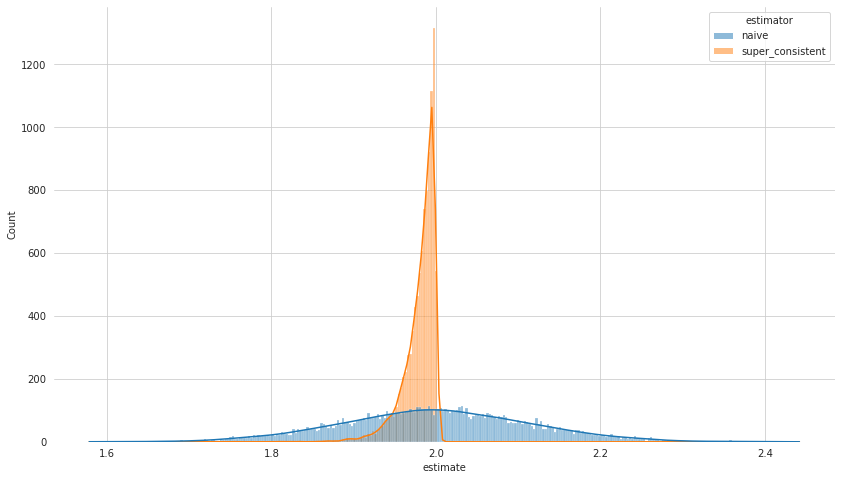

In [10]:
plt.box(False)
sns.histplot(df, x="estimate", hue="estimator", kde=True)

In [11]:
results = df.groupby("estimator").agg(["mean", "var"])
results.columns = ["mean", "variance"]
results["bias_squared"] = (results["mean"] - 2) ** 2
results = results.drop("mean", axis=1)
results

,variance,bias_squared
estimator,,
naive,0.013119,6.801363e-10
super_consistent,0.000385,3.788374e-04


In [12]:
pd.DataFrame(results.sum(axis=1), columns=["mean_squared_error"])

,mean_squared_error
estimator,
naive,0.013119
super_consistent,0.000764


## Problem 4.6

In [13]:
data_path = "https://www.ssc.wisc.edu/~bhansen/econometrics/cps09mar.txt"
raw_data = pd.read_csv(data_path, sep="\t", header=None)

In [14]:
df = raw_data[[3, 4]].copy().rename({3: "education", 4: "earnings"}, axis=1)

#### a) and b)

In [15]:
df.agg(["mean", "var"])

,education,earnings
mean,13.924619,5.509153e+04
var,7.531989,2.727145e+09


In [16]:
df.cov()

,education,earnings
education,7.531989,5.508999e+04
earnings,55089.985177,2.727145e+09


In [17]:
df.corr()

,education,earnings
education,1.000000,0.384383
earnings,0.384383,1.000000


#### c)

In [18]:
def confidence_interval(samples, alpha):
    """Compute confidence interval.

    Args:
        samples (pd.Series): Samples.
        alpha (float): Confidence parameter in [0, 1]. For a
            90%-confidence interval pass alpha = 0.9.

    Returns:
        interval (tuple): Lower and upper bound of the interval.

    """
    alpha = 1 - alpha
    n = len(samples)
    t_quantile = stats.t.ppf(1 - alpha / 2, n - 1)

    mean = samples.mean()
    std = samples.std()  # is normalized by (n-1)

    adjustment = t_quantile * std / np.sqrt(n)

    interval = (mean - adjustment, mean + adjustment)
    return interval

In [19]:
confidence_interval(df["education"], alpha=0.90)

(13.904578265773665, 13.944659052424278)

In [20]:
confidence_interval(df["earnings"], alpha=0.99)

(54494.35279667348, 55688.7085726064)

#### d)

Well ...

<AxesSubplot:xlabel='education', ylabel='Count'>

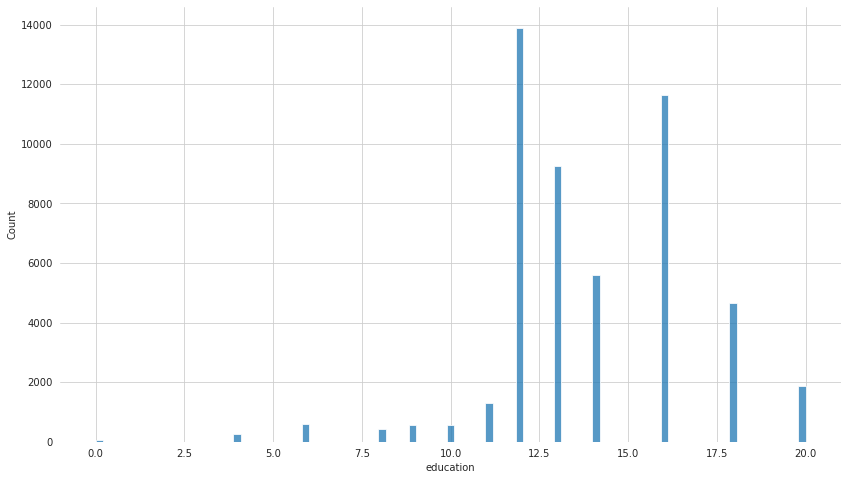

In [21]:
plt.box(False)
sns.histplot(df["education"])  # not normal

<AxesSubplot:xlabel='earnings', ylabel='Count'>

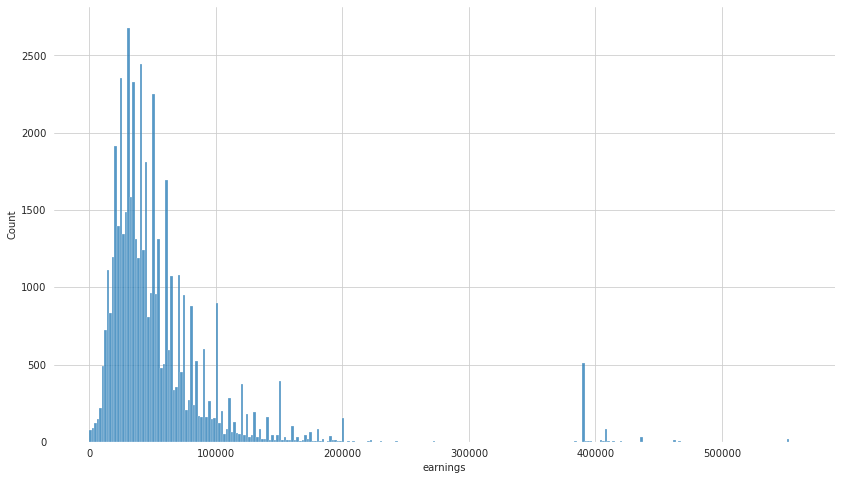

In [22]:
plt.box(False)
sns.histplot(df["earnings"])  # not normal